In [1]:
import sys
sys.path.insert(0, '../')
import ccob_qe_analysis_BOT as ana
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import numpy as np
from lsst.obs.lsst.cameraTransforms import LsstCameraTransforms
from lsst.obs.lsst import LsstCamMapper as camMapper

In [3]:
camera = camMapper._makeCamera()
lct = LsstCameraTransforms(camera)
basedir1 = '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/'
basedir2 = '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/'

path_to_data = {'R01': basedir1 + '6848D/BOT_acq/v0/48087/',
                'R02': basedir1 + '6849D/BOT_acq/v0/48093/',
                'R10': None,
                'R11': basedir1 + '6851D/BOT_acq/v0/48108/',
                'R12': basedir1 + '6852D/BOT_acq/v0/48113/',
                'R20': basedir1 + '6853D/BOT_acq/v0/48118/',
                'R21': None,
                'R22': basedir2 + '11974/BOT_acq/v0/93868/',
                'R30': basedir1 + '6843D/BOT_acq/v0/48047/'
               }
path_to_beam = '/home/combet/tmp_9rafts/60x60/'
outdir_figs = '/home/combet/tmp_9rafts/QE_results/'
outdir_fits = '/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/'
led_beam = 'uv'
led = 'uv'

model_ccdid = 'R22_S11'
beam_model = ana.load_beam_model(path_to_beam, led_name=led_beam, ref_amp=5, ccdid=model_ccdid)
delta_x, delta_y = ana.compute_offsets(beam_model, lct, ccdid=model_ccdid, ref_pix_x=2304, ref_pix_y=3003)

#raft_list = ['R22', 'R30', 'R01']
#raft_list = ['R02', 'R10', 'R12', 'R20']
raft_list = ['R22']#,'R02']
sensor_list = ['S00','S01','S02','S10','S11','S12','S20','S21','S22']
#sensor_list = ['S21','S22','S10','S11','S12','S20','S21','S22']
ccdid_list = sorted([raft+'_'+sensor for sensor in sensor_list for raft in raft_list])

for data_ccdid in ccdid_list:
    gainfile = '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage-test/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/6801D/fe55_analysis_BOT/v0/47706/'+data_ccdid+'_6801D_eotest_results.fits'

    raft = data_ccdid.split('_')[0]
    data = ana.qe_data.CcobQeData(data_ccdid, led, path_to_data[raft], gainfile, biasfile=None)
    data.find_dir()

#    pos = data.pos_list[2]
    for pos in data.pos_list:
        data.make_avg_mosaic_at_pos(pos, '/home/combet/tmp_9rafts/')
        mosaic = data.data[pos]['mosaic']
        bbox = ana.define_model_bbox(beam_model, mosaic, data.lct, pos, delta_x, delta_y)

        xarr = np.linspace(bbox[0],bbox[1],mosaic.shape[0])
        yarr = np.linspace(bbox[2],bbox[3],mosaic.shape[1])
        tmp = beam_model.beam_image['f_interp'](xarr, yarr) # interp works in cam coordinates
        tmp = np.flip(np.flip(tmp,axis=0),axis=1) # invert the model in x and in y 
        model_eotestDef = np.flip(tmp.T, axis=1) # beam model followinf EOTest convention
        model_normalised = model_eotestDef/np.max(model_eotestDef.flatten())
#        qe = mosaic/model_normalised
        qe = mosaic/model_eotestDef
        qe_norm = qe / np.mean(qe.flatten())

        outfile = outdir_fits+'fits/QE_'+data_ccdid+'_'+led+'_'+pos+'.fits'
        amp_coord = data.data[pos]['amp_coord']
        ana.make_fits(qe,amp_coord, outfile, data.template_file)

#        figfile = outdir_figs+'figs/QE_'+data_ccdid+'_'+led+'_'+pos+'_from_'+led_beam+'_norm.png'
        figfile = outdir_figs+'figs/QE_'+data_ccdid+'_'+led+'_'+pos+'_norm.png'
        ana.plot_results(qe_norm, model_normalised, mosaic, data_ccdid, data.lct, pos, delta_x, delta_y,figfile)



Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.175_-32.125_055/MC_C_20191027_000110_R22_S00.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.175_-32.125_056/MC_C_20191027_000111_R22_S00.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.175_-32.125_057/MC_C_20191027_000112_R22_S00.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.175_-32.125_058/MC_C_20191027_000113_R22_S00.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.175_-32.125_059/MC_C_20191027_000114_R22_S00.fits']
3.4172575250836097 14.959832775919727 37.54274247491639 25.080167224080274
40

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


23.89725752508361 14.959832775919727 17.06274247491639 25.080167224080274
40.96 40.04
(4004, 4096)
40.04
40.96
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-42.185_-42.365_085/MC_C_20191027_000140_R22_S00.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-42.185_-42.365_086/MC_C_20191027_000141_R22_S00.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-42.185_-42.365_087/MC_C_20191027_000142_R22_S00.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-42.185_-42.365_088/MC_C_20191027_000143_R22_S00.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-42.185_-42.365_089/MC

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


13.65725752508361 24.96983277591973 27.30274247491639 15.070167224080269
40.96 40.04
(4004, 4096)
40.04
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.195_-32.125_145/MC_C_20191027_000200_R22_S00.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.195_-32.125_146/MC_C_20191027_000201_R22_S00.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.195_-32.125_147/MC_C_20191027_000202_R22_S00.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.195_-32.125_148/MC_C_20191027_000203_R22_S00.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.195_-3

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


3.4172575250836097 34.97983277591973 37.54274247491639 5.060167224080269
40.959999999999994 40.04
(4004, 4096)
40.04
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.195_-52.605_115/MC_C_20191027_000170_R22_S00.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.195_-52.605_116/MC_C_20191027_000171_R22_S00.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.195_-52.605_117/MC_C_20191027_000172_R22_S00.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.195_-52.605_118/MC_C_20191027_000173_R22_S00.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


23.89725752508361 34.97983277591973 17.06274247491639 5.060167224080269
40.96 40.04
(4004, 4096)
40.04
40.96
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.305_-10.325_175/MC_C_20191027_000230_R22_S01.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.305_-10.325_176/MC_C_20191027_000231_R22_S01.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.305_-10.325_177/MC_C_20191027_000232_R22_S01.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.305_-10.325_178/MC_C_20191027_000233_R22_S01.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.305_-10.325_179/MC_C

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


23.89725752508361 14.95983277591973 17.06274247491639 25.08016722408027
40.96 40.04
(4004, 4096)
40.04
40.96
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.305_10.155_205/MC_C_20191027_000260_R22_S01.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.305_10.155_206/MC_C_20191027_000261_R22_S01.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.305_10.155_207/MC_C_20191027_000262_R22_S01.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.305_10.155_208/MC_C_20191027_000263_R22_S01.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.305_10.155_209/MC_C_2019

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


3.4172575250836097 14.95983277591973 37.54274247491639 25.08016722408027
40.959999999999994 40.04
(4004, 4096)
40.04
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-42.315_-0.085_235/MC_C_20191027_000290_R22_S01.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-42.315_-0.085_236/MC_C_20191027_000291_R22_S01.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-42.315_-0.085_237/MC_C_20191027_000292_R22_S01.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-42.315_-0.085_238/MC_C_20191027_000293_R22_S01.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


13.65725752508361 24.96983277591973 27.30274247491639 15.070167224080269
40.96 40.04
(4004, 4096)
40.04
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.325_-10.325_265/MC_C_20191027_000320_R22_S01.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.325_-10.325_266/MC_C_20191027_000321_R22_S01.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.325_-10.325_267/MC_C_20191027_000322_R22_S01.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.325_-10.325_268/MC_C_20191027_000323_R22_S01.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.325_-1

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


23.89725752508361 34.97983277591973 17.06274247491639 5.060167224080269
40.96 40.04
(4004, 4096)
40.04
40.96
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.325_10.155_295/MC_C_20191027_000350_R22_S01.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.325_10.155_296/MC_C_20191027_000351_R22_S01.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.325_10.155_297/MC_C_20191027_000352_R22_S01.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.325_10.155_298/MC_C_20191027_000353_R22_S01.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.325_10.155_299/MC_C_2019

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


3.4172575250836097 34.97983277591973 37.54274247491639 5.060167224080269
40.959999999999994 40.04
(4004, 4096)
40.04
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.355_31.945_325/MC_C_20191027_000380_R22_S02.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.355_31.945_326/MC_C_20191027_000381_R22_S02.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.355_31.945_327/MC_C_20191027_000382_R22_S02.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.355_31.945_328/MC_C_20191027_000383_R22_S02.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


23.89725752508361 14.959832775919727 17.06274247491639 25.080167224080274
40.96 40.04
(4004, 4096)
40.04
40.96
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.355_52.425_355/MC_C_20191027_000410_R22_S02.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.355_52.425_356/MC_C_20191027_000411_R22_S02.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.355_52.425_357/MC_C_20191027_000412_R22_S02.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.355_52.425_358/MC_C_20191027_000413_R22_S02.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-32.355_52.425_359/MC_C_20

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


3.4172575250836097 14.959832775919727 37.54274247491639 25.080167224080274
40.959999999999994 40.04
(4004, 4096)
40.04
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-42.365_42.185_385/MC_C_20191027_000440_R22_S02.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-42.365_42.185_386/MC_C_20191027_000441_R22_S02.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-42.365_42.185_387/MC_C_20191027_000442_R22_S02.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-42.365_42.185_388/MC_C_20191027_000443_R22_S02.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


13.65725752508361 24.96983277591973 27.30274247491639 15.070167224080269
40.96 40.04
(4004, 4096)
40.04
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.375_31.945_415/MC_C_20191027_000470_R22_S02.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.375_31.945_416/MC_C_20191027_000471_R22_S02.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.375_31.945_417/MC_C_20191027_000472_R22_S02.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.375_31.945_418/MC_C_20191027_000473_R22_S02.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.375_31.945

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


23.89725752508361 34.97983277591973 17.06274247491639 5.060167224080269
40.96 40.04
(4004, 4096)
40.04
40.96
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.375_52.425_445/MC_C_20191027_000500_R22_S02.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.375_52.425_446/MC_C_20191027_000501_R22_S02.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.375_52.425_447/MC_C_20191027_000502_R22_S02.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.375_52.425_448/MC_C_20191027_000503_R22_S02.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-52.375_52.425_449/MC_C_2019

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


3.4172575250836097 34.97983277591973 37.54274247491639 5.060167224080269
40.959999999999994 40.04
(4004, 4096)
40.04
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-9.925_-32.075_595/MC_C_20191027_000650_R22_S10.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-9.925_-32.075_596/MC_C_20191027_000651_R22_S10.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-9.925_-32.075_597/MC_C_20191027_000652_R22_S10.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-9.925_-32.075_598/MC_C_20191027_000653_R22_S10.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


3.4172575250836146 34.97983277591973 37.54274247491639 5.060167224080271
40.96 40.040000000000006
(4004, 4096)
40.040000000000006
40.96
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-9.925_-52.555_565/MC_C_20191027_000620_R22_S10.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-9.925_-52.555_566/MC_C_20191027_000621_R22_S10.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-9.925_-52.555_567/MC_C_20191027_000622_R22_S10.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-9.925_-52.555_568/MC_C_20191027_000623_R22_S10.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


23.89725752508361 34.97983277591973 17.06274247491639 5.060167224080271
40.96 40.040000000000006
(4004, 4096)
40.040000000000006
40.96
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_0.085_-42.315_535/MC_C_20191027_000590_R22_S10.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_0.085_-42.315_536/MC_C_20191027_000591_R22_S10.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_0.085_-42.315_537/MC_C_20191027_000592_R22_S10.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_0.085_-42.315_538/MC_C_20191027_000593_R22_S10.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_0.085_

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


13.65725752508361 24.96983277591973 27.30274247491639 15.070167224080272
40.96 40.040000000000006
(4004, 4096)
40.040000000000006
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_10.095_-32.075_505/MC_C_20191027_000560_R22_S10.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_10.095_-32.075_506/MC_C_20191027_000561_R22_S10.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_10.095_-32.075_507/MC_C_20191027_000562_R22_S10.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_10.095_-32.075_508/MC_C_20191027_000563_R22_S10.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


3.4172575250836146 14.959832775919727 37.54274247491639 25.080167224080274
40.96 40.04
(4004, 4096)
40.04
40.96
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_10.095_-52.555_475/MC_C_20191027_000530_R22_S10.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_10.095_-52.555_476/MC_C_20191027_000531_R22_S10.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_10.095_-52.555_477/MC_C_20191027_000532_R22_S10.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_10.095_-52.555_478/MC_C_20191027_000533_R22_S10.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_10.095_-52.555_479/MC_C_2

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


23.89725752508361 14.959832775919727 17.06274247491639 25.080167224080274
40.96 40.04
(4004, 4096)
40.04
40.96
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-10.005_-10.235_715/MC_C_20191027_000770_R22_S11.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-10.005_-10.235_716/MC_C_20191027_000771_R22_S11.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-10.005_-10.235_717/MC_C_20191027_000772_R22_S11.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-10.005_-10.235_718/MC_C_20191027_000773_R22_S11.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-10.005_-10.235_719/MC

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


23.897257525083607 34.97983277591973 17.062742474916394 5.060167224080268
40.96 40.04
(4004, 4096)
40.04
40.96
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-10.005_10.245_745/MC_C_20191027_000800_R22_S11.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-10.005_10.245_746/MC_C_20191027_000801_R22_S11.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-10.005_10.245_747/MC_C_20191027_000802_R22_S11.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-10.005_10.245_748/MC_C_20191027_000803_R22_S11.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-10.005_10.245_749/MC_C_20

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


3.4172575250836097 34.97983277591973 37.54274247491639 5.060167224080268
40.959999999999994 40.04
(4004, 4096)
40.04
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_0.005_0.005_685/MC_C_20191027_000740_R22_S11.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_0.005_0.005_686/MC_C_20191027_000741_R22_S11.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_0.005_0.005_687/MC_C_20191027_000742_R22_S11.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_0.005_0.005_688/MC_C_20191027_000743_R22_S11.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_0.005_0.005_6

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


13.65725752508361 24.96983277591973 27.30274247491639 15.070167224080269
40.96 40.04
(4004, 4096)
40.04
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_10.015_-10.235_625/MC_C_20191027_000680_R22_S11.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_10.015_-10.235_626/MC_C_20191027_000681_R22_S11.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_10.015_-10.235_627/MC_C_20191027_000682_R22_S11.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_10.015_-10.235_628/MC_C_20191027_000683_R22_S11.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_10.015_-10.235

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


23.897257525083607 14.95983277591973 17.062742474916394 25.08016722408027
40.96 40.04
(4004, 4096)
40.04
40.96
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_10.015_10.245_655/MC_C_20191027_000710_R22_S11.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_10.015_10.245_656/MC_C_20191027_000711_R22_S11.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_10.015_10.245_657/MC_C_20191027_000712_R22_S11.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_10.015_10.245_658/MC_C_20191027_000713_R22_S11.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_10.015_10.245_659/MC_C_2019102

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


3.4172575250836097 14.95983277591973 37.54274247491639 25.08016722408027
40.959999999999994 40.04
(4004, 4096)
40.04
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-0.095_42.285_835/MC_C_20191027_000890_R22_S12.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-0.095_42.285_836/MC_C_20191027_000891_R22_S12.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-0.095_42.285_837/MC_C_20191027_000892_R22_S12.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-0.095_42.285_838/MC_C_20191027_000893_R22_S12.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-0.09

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


13.65725752508361 24.96983277591973 27.30274247491639 15.070167224080272
40.96 40.040000000000006
(4004, 4096)
40.040000000000006
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-10.105_32.045_865/MC_C_20191027_000920_R22_S12.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-10.105_32.045_866/MC_C_20191027_000921_R22_S12.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-10.105_32.045_867/MC_C_20191027_000922_R22_S12.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-10.105_32.045_868/MC_C_20191027_000923_R22_S12.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


23.89725752508361 34.97983277591973 17.06274247491639 5.0601672240802715
40.96 40.040000000000006
(4004, 4096)
40.040000000000006
40.96
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-10.105_52.525_895/MC_C_20191027_000950_R22_S12.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-10.105_52.525_896/MC_C_20191027_000951_R22_S12.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-10.105_52.525_897/MC_C_20191027_000952_R22_S12.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-10.105_52.525_898/MC_C_20191027_000953_R22_S12.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_-

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


3.4172575250836097 34.97983277591973 37.54274247491639 5.0601672240802715
40.959999999999994 40.040000000000006
(4004, 4096)
40.040000000000006
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_9.915_32.045_775/MC_C_20191027_000830_R22_S12.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_9.915_32.045_776/MC_C_20191027_000831_R22_S12.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_9.915_32.045_777/MC_C_20191027_000832_R22_S12.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_9.915_32.045_778/MC_C_20191027_000833_R22_S12.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


23.89725752508361 14.95983277591973 17.06274247491639 25.08016722408027
40.96 40.04
(4004, 4096)
40.04
40.96
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_9.915_52.525_805/MC_C_20191027_000860_R22_S12.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_9.915_52.525_806/MC_C_20191027_000861_R22_S12.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_9.915_52.525_807/MC_C_20191027_000862_R22_S12.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_9.915_52.525_808/MC_C_20191027_000863_R22_S12.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_9.915_52.525_809/MC_C_20191027_00086

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


3.4172575250836097 14.95983277591973 37.54274247491639 25.08016722408027
40.959999999999994 40.04
(4004, 4096)
40.04
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.355_-31.945_1045/MC_C_20191027_001100_R22_S20.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.355_-31.945_1046/MC_C_20191027_001101_R22_S20.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.355_-31.945_1047/MC_C_20191027_001102_R22_S20.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.355_-31.945_1048/MC_C_20191027_001103_R22_S20.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


3.4172575250836097 34.97983277591974 37.54274247491639 5.060167224080264
40.959999999999994 40.040000000000006
(4004, 4096)
40.040000000000006
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.355_-52.425_1015/MC_C_20191027_001070_R22_S20.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.355_-52.425_1016/MC_C_20191027_001071_R22_S20.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.355_-52.425_1017/MC_C_20191027_001072_R22_S20.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.355_-52.425_1018/MC_C_20191027_001073_R22_S20.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


23.89725752508361 34.97983277591974 17.06274247491639 5.060167224080264
40.96 40.040000000000006
(4004, 4096)
40.040000000000006
40.96
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_42.365_-42.185_985/MC_C_20191027_001040_R22_S20.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_42.365_-42.185_986/MC_C_20191027_001041_R22_S20.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_42.365_-42.185_987/MC_C_20191027_001042_R22_S20.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_42.365_-42.185_988/MC_C_20191027_001043_R22_S20.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_42

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


13.65725752508361 24.96983277591973 27.30274247491639 15.070167224080269
40.96 40.04
(4004, 4096)
40.04
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.375_-31.945_955/MC_C_20191027_001010_R22_S20.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.375_-31.945_956/MC_C_20191027_001011_R22_S20.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.375_-31.945_957/MC_C_20191027_001012_R22_S20.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.375_-31.945_958/MC_C_20191027_001013_R22_S20.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.375_-31.945

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


3.4172575250836097 14.95983277591973 37.54274247491639 25.08016722408027
40.959999999999994 40.04
(4004, 4096)
40.04
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.375_-52.425_925/MC_C_20191027_000980_R22_S20.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.375_-52.425_926/MC_C_20191027_000981_R22_S20.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.375_-52.425_927/MC_C_20191027_000982_R22_S20.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.375_-52.425_928/MC_C_20191027_000983_R22_S20.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_5

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


23.89725752508361 14.95983277591973 17.06274247491639 25.08016722408027
40.96 40.04
(4004, 4096)
40.04
40.96
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.275_-10.135_1165/MC_C_20191027_001220_R22_S21.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.275_-10.135_1166/MC_C_20191027_001221_R22_S21.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.275_-10.135_1167/MC_C_20191027_001222_R22_S21.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.275_-10.135_1168/MC_C_20191027_001223_R22_S21.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.275_-10.135_1169/MC_C

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


23.89725752508361 34.97983277591973 17.06274247491639 5.060167224080269
40.96 40.04
(4004, 4096)
40.04
40.96
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.275_10.345_1195/MC_C_20191027_001250_R22_S21.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.275_10.345_1196/MC_C_20191027_001251_R22_S21.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.275_10.345_1197/MC_C_20191027_001252_R22_S21.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.275_10.345_1198/MC_C_20191027_001253_R22_S21.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.275_10.345_1199/MC_C_2019

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


3.4172575250836097 34.97983277591973 37.54274247491639 5.060167224080269
40.959999999999994 40.04
(4004, 4096)
40.04
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_42.285_0.105_1135/MC_C_20191027_001190_R22_S21.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_42.285_0.105_1136/MC_C_20191027_001191_R22_S21.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_42.285_0.105_1137/MC_C_20191027_001192_R22_S21.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_42.285_0.105_1138/MC_C_20191027_001193_R22_S21.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_42.28

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


13.65725752508361 24.96983277591973 27.30274247491639 15.070167224080269
40.96 40.04
(4004, 4096)
40.04
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.295_-10.135_1075/MC_C_20191027_001130_R22_S21.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.295_-10.135_1076/MC_C_20191027_001131_R22_S21.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.295_-10.135_1077/MC_C_20191027_001132_R22_S21.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.295_-10.135_1078/MC_C_20191027_001133_R22_S21.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.295_-10

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


23.89725752508361 14.95983277591973 17.06274247491639 25.08016722408027
40.96 40.04
(4004, 4096)
40.04
40.96
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.295_10.345_1105/MC_C_20191027_001160_R22_S21.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.295_10.345_1106/MC_C_20191027_001161_R22_S21.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.295_10.345_1107/MC_C_20191027_001162_R22_S21.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.295_10.345_1108/MC_C_20191027_001163_R22_S21.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.295_10.345_1109/MC_C_2019

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


3.4172575250836097 14.95983277591973 37.54274247491639 25.08016722408027
40.959999999999994 40.04
(4004, 4096)
40.04
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.195_32.125_1315/MC_C_20191027_001370_R22_S22.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.195_32.125_1316/MC_C_20191027_001371_R22_S22.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.195_32.125_1317/MC_C_20191027_001372_R22_S22.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.195_32.125_1318/MC_C_20191027_001373_R22_S22.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_3

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


23.89725752508361 34.97983277591973 17.06274247491639 5.060167224080269
40.96 40.04
(4004, 4096)
40.04
40.96
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.195_52.605_1345/MC_C_20191027_001400_R22_S22.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.195_52.605_1346/MC_C_20191027_001401_R22_S22.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.195_52.605_1347/MC_C_20191027_001402_R22_S22.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.195_52.605_1348/MC_C_20191027_001403_R22_S22.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_32.195_52.605_1349/MC_C_2019

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


3.4172575250836097 34.97983277591973 37.54274247491639 5.060167224080269
40.959999999999994 40.04
(4004, 4096)
40.04
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_42.205_42.365_1285/MC_C_20191027_001340_R22_S22.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_42.205_42.365_1286/MC_C_20191027_001341_R22_S22.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_42.205_42.365_1287/MC_C_20191027_001342_R22_S22.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_42.205_42.365_1288/MC_C_20191027_001343_R22_S22.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_4

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


13.65725752508361 24.96983277591973 27.30274247491639 15.070167224080269
40.96 40.04
(4004, 4096)
40.04
40.959999999999994
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.215_32.125_1225/MC_C_20191027_001280_R22_S22.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.215_32.125_1226/MC_C_20191027_001281_R22_S22.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.215_32.125_1227/MC_C_20191027_001282_R22_S22.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.215_32.125_1228/MC_C_20191027_001283_R22_S22.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.215_32.125_

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


23.89725752508361 14.95983277591973 17.06274247491639 25.08016722408027
40.96 40.04
(4004, 4096)
40.04
40.96
Averaging the following files:

['/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.215_52.605_1255/MC_C_20191027_001310_R22_S22.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.215_52.605_1256/MC_C_20191027_001311_R22_S22.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.215_52.605_1257/MC_C_20191027_001312_R22_S22.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.215_52.605_1258/MC_C_20191027_001313_R22_S22.fits'
 '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-10134_Cryostat/LCA-10134_Cryostat-0001/11974/BOT_acq/v0/93868/ccob_uv_52.215_52.605_1259/MC_C_2019

../ccob_qe_data.py:84: ResourceWarning: unclosed file <_io.FileIO name='/home/combet/tmp_9rafts/tmp.fits' mode='rb' closefd=True>
  mosaic, amp_coord = u.make_ccd_2d_array(tmp_file, gains=self.gains, biasfile=self.biasfile)


3.4172575250836097 14.95983277591973 37.54274247491639 25.08016722408027
40.959999999999994 40.04
(4004, 4096)
40.04
40.959999999999994


In [6]:
print(delta_x, delta_y)

709.0301003344484 -494.9832775919731


In [25]:
import lsst.eotest.sensor as sensorTest
import lsst.eotest.raft as eotest_raft
import lsst.eotest.image_utils as imutils
from lsst.eotest.sensor.EOTestPlots import cmap_range
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib

In [19]:
def plot(dd, title=None, cmap=plt.cm.hot, nsig=5, figsize=(10, 10),
             binsize=10, flipx=True, textcolor='c', annotation='',
             rotate180=False):
        """
        Render the raft mosaic.
        Parameters
        ----------
        title : str, optional
            The plot title. If None (default), then build the title
            from the RAFTNAME and MONOWL primary header keyword values.
        cmap : matplotlib.colors.Colormap, optional
            The color map to use. Default: matplotlib.pyplot.cm.hot.
        nsig : float, optional
            The n-sigma value for the sigma clipping used to determine
            the pixel value range over which the color map is mapped.
        figsize : (float, float), optional
            The width x height size of the figure in inches. Default: (10, 10).
        binsize : int, optional
            Rebin the plotted image data by binsize*binsize,
            averging over the coarser bin.  Default: 10
        flipx : bool, optional
            Flip full raft mosaic in x so that parity of image matches
            LCA-13381. Default: True
        textcolor : str, optional
            Color of the text for the segment and sensor labeling.
            Default: 'c' (cyan)
        annotation : str, optional
            Description of the plot, e.g., pixel units (ADU or e-),
            gain-corrected, bias-subtracted.  Default: ''
        rotate180 : bool [False]
            Flag to rotate the mosaic by 180 degrees to match the
            orientation of the focalplane mosiacs created for the
            BOT-level plots.
        """
        plt.rcParams['figure.figsize'] = figsize
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        output_array = imutils.rebin_array(dd.image_array, binsize,
                                           use_mean=True)
        if flipx:
            output_array = output_array[:, ::-1]
        if rotate180:
            ny, nx = output_array.shape
            rotated_array = np.zeros((nx, ny), dtype=output_array.dtype)
            for j in range(ny):
                rotated_array[:, ny-1-j] = output_array[::-1, j]
            output_array = rotated_array
        image = ax.imshow(output_array, interpolation='nearest', cmap=cmap)
        # Set range and normalization of color map based on sigma-clip
        # of pixel values.
        vmin, vmax = cmap_range(output_array, nsig=nsig)
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        image.set_norm(norm)
        if title is None:
            title = "%s, %i nm" % (dd.raft_name, dd.wl)
        ax.set_title(title)
        fig.colorbar(image)
        # Turn off ticks and tick labels for x- and y-axes.
        plt.tick_params(axis='both', which='both',
                        top='off', bottom='off', left='off', right='off',
                        labelbottom='off', labelleft='off')
        # Label segments by sensor bay and segment number.
        for slot in dd.fits_files:
            seg_coords = list(dd._amp_coords[slot].values())[-8]
            xmin, xmax, ymin, ymax = seg_coords
            xx = float(xmax + xmin)/2./float(dd.nx)
            if flipx:
                xx = 1 - xx
            yy = 1. - (float(ymax - ymin)*0.05 + ymin)/float(dd.ny)
            if rotate180:
                xx = 1 - xx - 7*np.abs(xmax - xmin)/float(dd.nx)
                yy = 1 - yy + 1.9*np.abs(ymax - ymin)/float(dd.ny)
            plt.annotate('%s' % slot,
                         (xx, yy), xycoords='axes fraction',
                         size='x-small', horizontalalignment='center',
                         verticalalignment='center', color=textcolor)
            for amp, seg_coords in list(dd._amp_coords[slot].items()):
                xmin, xmax, ymin, ymax = seg_coords
                xx = float(xmax + xmin)/2./float(dd.nx)
                if flipx:
                    xx = 1. - xx
                if amp <= 8:
                    yy = 1. - (float(ymax - ymin)*0.85 + ymin)/float(dd.ny)
                else:
                    yy = 1. - (float(ymax - ymin)*0.15 + ymin)/float(dd.ny)
                if rotate180:
                    xx = 1 - xx
                    yy = 1 - yy
                plt.annotate('%s' % imutils.channelIds[amp],
                             (xx, yy), xycoords='axes fraction',
                             size='x-small', horizontalalignment='center',
                             verticalalignment='center', color=textcolor)
        plt.annotate(annotation, (1, -0.1), xycoords='axes fraction',
                     horizontalalignment='right', verticalalignment='bottom')
        return fig

In [21]:
raft = 'R22'
slot_names=['S00','S01','S02','S10','S11','S12','S20','S21','S22']
led = 'blue'
#slot = slot_names[0]
#sorted(glob.glob(f'/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_{raft}_{slot}_{led}*'))[2]
#[(glob.glob(f'/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_{raft}_{slot}_{led}*')[2])[0] for slot in slot_names]
fits_files_dict ={slot : sorted(glob.glob(f'/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_{raft}_{slot}_{led}*'))[2] for slot in slot_names}
fits_files_dict

{'S00': '/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R22_S00_blue_-42.185_-42.365.fits',
 'S01': '/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R22_S01_blue_-42.315_-0.085.fits',
 'S02': '/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R22_S02_blue_-42.365_42.185.fits',
 'S10': '/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R22_S10_blue_0.085_-42.315.fits',
 'S11': '/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R22_S11_blue_0.005_0.005.fits',
 'S12': '/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R22_S12_blue_-10.105_52.525.fits',
 'S20': '/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R22_S20_blue_42.365_-42.185.fits',
 'S21': '/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R22_S21_blue_42.285_0.105.fits',
 'S22': '/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R22_S22_blue_42.205_42.365.fits'}

In [22]:
dd = eotest_raft.RaftMosaic(fits_files_dict)

In [23]:
raft_name = dd.raft_name.split('_')[1]

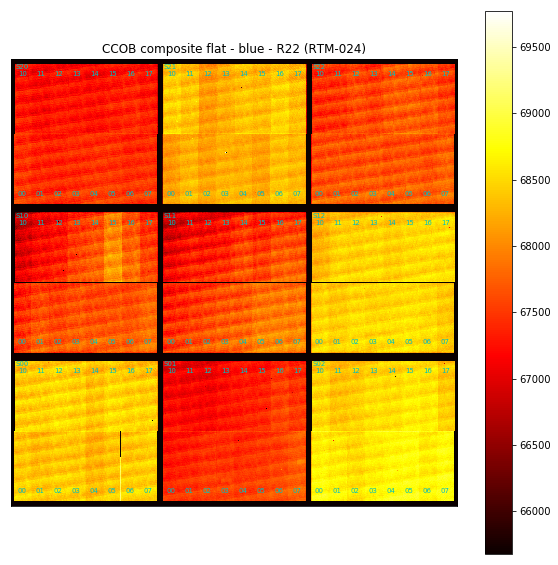

In [26]:
tmp = plot(dd,rotate180=True, nsig=4, title=f'CCOB composite flat - {led} - {raft} ({raft_name})')

In [129]:
outdir_figs = '/home/combet/tmp_9rafts/QE_results/figs/'
tmp.savefig(outdir_figs+f'{raft}_flat_{led}.png')

In [9]:
from astropy.io import fits as fits

In [11]:
hdu = fits.open('/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S00_blue_-286.285_-32.685.fits')

In [12]:
hdu[0].header

SIMPLE  =                    T                                                  
BITPIX  =                    8                                                  
NAXIS   =                    0                                                  
EXTEND  =                    T                                                  
DATE    = '2019-10-29T00:08:04.755'                                             
DATE-OBS= '2019-10-29T00:08:02.382'                                             
MJD     =    58785.00561059033                                                  
MJD-OBS =    58785.00558312517                                                  
RUNNUM  = '6849D   '                                                            
IMAGETAG= '9542824df285a9a7'                                                    
TSTAND  = 'BOT     '                                                            
INSTRUME= 'lsstCam '                                                            
CONTNUM = '189223f9'        

In [16]:
import ccob_utils as u
f1 = '/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R22_S11_red_0.005_0.005.fits'
im, dum = u.make_ccd_2d_array(f1)

In [14]:
f2 = '/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R22_S11_red_10.015_-10.235.fits'
im2, dum = u.make_ccd_2d_array(f2)

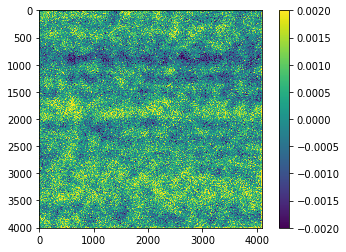

In [24]:
import scipy
#residuals = (im-im2)*100/im
residuals = scipy.ndimage.filters.gaussian_filter((im-im2)/im, 1, mode='constant')
plt.imshow(residuals, vmin=-0.002, vmax=0.002)
plt.colorbar()